In [14]:
import numpy as np 
import progressbar
from GPyOpt.methods import BayesianOptimization

In [15]:
# honest network delay over next n blocks.
def vectorDelayHonest(ps, es, init_endorsers = 24, delay_priority = 40, delay_endorse = 8):
    return (60 * len(ps)
           + delay_priority * sum(ps) 
           + sum([delay_endorse * max(init_endorsers - e, 0) for e in es]))

# attacking network delay over next n blocks.
def vectorDelayAttacker(ps, es, init_endorsers = 24, delay_priority = 40, delay_endorse = 8):
    return (60 * len(ps) 
           + delay_priority * sum(ps) 
           + sum([delay_endorse * max(init_endorsers - e, 0) for e in es[1:]]))

# efficient sample generation
def getAH(alpha):
    x = np.random.geometric(1-alpha)
    if x == 1:
        h = 0
        a = np.random.geometric(alpha)
    else:
        a = 0
        h = x - 1
    return [a, h]

def rewardBlock(p, e):
    if p == 0:
        return e * 1.25
    return e * 0.1875

def rewardEndorsement(p):
    if p == 0:
        return 1.25
    return 0.8333333

def calcHonestSingle(p, e):
    if p == 0:
        return rewardBlock(0, 32) + e * rewardEndorsement(0)
    return e * rewardEndorsement(0)

def calcAttackSingle(p, e):
    return rewardBlock(p, e) + e * rewardEndorsement(p)

def vectorRewardHonest(ps, es):
    totalReward = 0
    for i in range(len(ps)):
        totalReward += calcHonestSingle(ps[i], es[i])
    return totalReward

def vectorRewardAttack(ps, es):
    totalReward = calcAttackSingle(ps[0], 32)
    for i in range(1,len(ps)):
        totalReward += calcAttackSingle(ps[i], es[i])
    return totalReward

def calcCosts(ps, es):
    return vectorRewardHonest(ps, es) - vectorRewardAttack(ps, es)

In [16]:
def getProbReorg(alpha, length, sample_size = int(1e5), init_endorsers = 24, delay_priority = 40, delay_endorse = 8):
    bar = progressbar.ProgressBar()
    feasible_count = 0
    for _ in bar(range(sample_size)):
        aVals = []
        hVals = []
        for i in range(length):
            a, h = getAH(alpha)
            aVals.append(a)
            hVals.append(h)
        eVals = np.random.binomial(32, alpha, size = length)
        honest_delay = vectorDelayHonest(hVals, 32 - eVals)
        selfish_delay = vectorDelayAttacker(aVals, eVals)
        if selfish_delay <= honest_delay:
            feasible_count += 1
    return feasible_count / sample_size

In [17]:
def getProbSelfish(alpha, length, sample_size = int(1e5), init_endorsers = 24, delay_priority = 40, delay_endorse = 8):
    bar = progressbar.ProgressBar()
    feasible_count = 0
    for _ in bar(range(sample_size)):
        aVals = []
        hVals = []
        for i in range(length):
            a, h = getAH(alpha)
            aVals.append(a)
            hVals.append(h)
        eVals = np.random.binomial(32, alpha, size = length)
        honest_delay = vectorDelayHonest(hVals, 32 - eVals)
        selfish_delay = vectorDelayAttacker(aVals, eVals)
        if selfish_delay <= honest_delay:
            feasible_count += 1
    return feasible_count / sample_size

In [18]:
weights_alphas = [(1.0, 0.3), (0.8, 0.35), (0.6, 0.4), (0.4, 0.45), (0.2, 0.49)]

def combined(alpha, length, sample_size = int(1e4), init_endorsers = 24, delay_priority = 40, delay_endorse = 8):
    return getProbReorg(alpha, length, sample_size, init_endorsers, delay_priority, delay_endorse) + getProbSelfish(alpha, length, sample_size, init_endorsers, delay_priority, delay_endorse)

def objective(inputs):
    return sum([weight * combined(alpha = alpha, length = 20, init_endorsers = inputs[0][0], delay_priority = inputs[0][1], delay_endorse = inputs[0][2]) for (weight, alpha) in weights_alphas])
domain = [{'name': 'init_endorsers', 'type': 'discrete', 'domain': tuple(range(33))}, 
        {'name': 'delay_priority', 'type': 'discrete', 'domain': tuple(range(100))}, 
        {'name': 'delay_endorse', 'type': 'discrete', 'domain': tuple(range(100))}]

In [21]:
opt = BayesianOptimization(f = objective, domain = domain)
opt.run_optimization(max_iter = 100)

100% (10000 of 10000) |##################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (10000 of 10000) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (10000 of 10000) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (10000 of 10000) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (10000 of 10000) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (10000 of 10000) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (10000 of 10000) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (10000 of 10000) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (10000 of 10000) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (10000 of 10000) |##################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (10000 of 10000) |##################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (10000 of 10000) |##################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (10000 of 10000) |#################

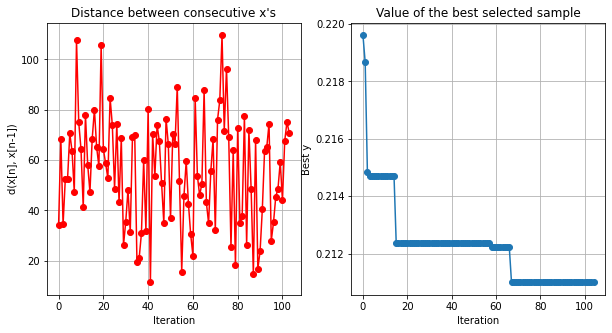

15% (1519 of 10000) |##                 | Elapsed Time: 0:00:00 ETA:   0:00:00
X = [init_endorsers delay_priority delay_endorse]

All tested values of X : 
[[20. 14. 40.]
 [12. 19.  7.]
 [ 5. 82. 33.]
 [20. 53. 22.]
 [28. 55. 74.]
 [21. 53. 22.]
 [ 2. 30. 86.]
 [31. 50. 33.]
 [26.  4. 43.]
 [31. 97. 97.]
 [14. 95. 24.]
 [24. 35.  3.]
 [ 7.  1. 19.]
 [28. 76. 20.]
 [ 0. 28. 37.]
 [ 3.  3. 77.]
 [10. 43. 22.]
 [ 6. 18. 98.]
 [17. 51. 43.]
 [ 7. 89. 85.]
 [ 6.  0. 28.]
 [14. 54. 62.]
 [ 9. 34.  7.]
 [18. 86.  8.]
 [17. 69. 91.]
 [ 1. 45. 23.]
 [31. 82. 33.]
 [ 3. 18. 59.]
 [ 6. 40. 96.]
 [15. 43. 28.]
 [ 3. 27. 11.]
 [19. 58. 18.]
 [17. 31. 58.]
 [15.  3. 72.]
 [19. 24.  6.]
 [23. 44. 73.]
 [23. 26. 80.]
 [13. 21. 62.]
 [11. 46. 80.]
 [21. 43. 21.]
 [12. 14. 31.]
 [ 9. 94. 37.]
 [17. 98. 30.]
 [29. 53. 83.]
 [ 7. 72. 38.]
 [27.  2. 52.]
 [ 1. 57. 23.]
 [28. 61. 66.]
 [17. 94. 69.]
 [22. 23. 97.]
 [ 5. 43. 36.]
 [ 4. 29.  2.]
 [30. 61. 59.]
 [14. 17. 12.]
 [ 4. 94. 56.]
 [10. 43. 52.]
 [11

In [22]:
opt.plot_convergence()
print("\nX = [init_endorsers delay_priority delay_endorse]")
print("\nAll tested values of X : \n" + str(opt.X))
print("\nCorresponding values of Y : \n" + str(opt.Y))
print("\nOptimal X : \n" + str(opt.x_opt))
print("\nOptimal Y : \n" + str(objective([opt.x_opt])))
print("\nCurrent Tezos : \n" + str(objective([[24, 40, 8]])))